### Custom ML model to identify local similarities ("links") with sequence profiles

Let $$X \in \{0,1\}^{B\times N\times 6 \times T \times 22}$$ be a batch of **one-hot encoded input translated sequences**,
where $B$ is `batch_size`, $N$ is the number of genomes and $T$ is the `tile_size` (in aa).
The 6 is here the number of translated frames in order (0,+),(1,+),(2,+),(0,-),(1,-),(2,-).
The 22 is here the size of the considered amino acid alphabet.


In [1]:
import numpy as np
import tensorflow as tf

import sequtils as su
import seq

### Create random genomes as toy data 

In [2]:
N = 4           # number of genomes
tile_size = 20  # tile size measured in amino acids
# A tile is a consecutive subsequence of _one_ contig/scaffold/chromosome.
# Tiles should be about gene-sized.

genome_sizes = [[210,100], [30,220,150], [230,110,120,90], [180]] # in nucleotides
genomes = seq.getRandomGenomes(N, tile_size, genome_sizes)

In [3]:
genomes

[['CTATCAATGACGTAGATAAGGAAGGAGGTCAGCTAGCAGATAGGACGTACTTGCGATTACTATATAGGATTAGACGAGCGTCACTGGGTTTTATAAGGCTCAGTTGTCAGCTGCAATAAGGGTTCACGCCCCAAGATGCTGAACGTTGCAGCCTCAATTGATGCGGCATACGGCCCATAGATCCACTTTGTGCAAATCTTAGTCACGTAA',
  'CGTATCCCAAGTGCATGCAGGACTGATTCACTTTGAGCTCTTAATTATGCGATGGAAGAGAGAATATATGTATTTCCGTCACGACCCGAACTACGCCACA'],
 ['ACTGCAATATTAACTGCCGGACGATCCACA',
  'GCCAATCGTCTGCTTGTCACAACCGCAAAGCCTCTAAGCGCTTTGCCCCGATCTATAACATTGTGGGGCCGGAATATAACTGAGTGAGAGAGCCGGCCGACGGGTTATATTATTCCCCTCGTTGCAAGGGGGACTGTACGAATTAGCGCTGCGTGCAACGTTGATGACCTTACTGCTCAATCTTTGGTAGTCGCGTAAGGACTCACCACTAACTTGGAAA',
  'GTGTTAACCTACCTATAGGCCAACGACAACTCCGACGAAATAGGGGGCATCGATGGCCGAACTGTTTATCGCCTATGGAGACCGTAAGGATCATCTGCTGTTCTCCAAAAGGGCGCCATTCTCGGCCCACGCGGAAACGCCCCCGCGTTT'],
 ['GAGAGACATACAAATGTATATAACATCAACCATCAGTCTTAACTCTTGATTATGTCAGCTGGAAATAAAGTAAGAGGGCGAACTAGTCTAAAACGGACGTTCTCTGTAGCCGATTGTAATTTCACGTACAACCGAATCGCATATGTGACACTGGGAGAAGAAGCAAGTCGTGTCCTGATTAAAAATTCAGAGATTGTCTAAAGATAGTTTGTGAAACTGTTCGTTCTTTT',
  'CTGCGAGTATCAAACGGTT

In [4]:
Q = seq.backGroundAAFreqs(genomes, True)

background freqs:  2840.0 *
C 0.0310
K 0.0320
E 0.0310
W 0.0120
T 0.0616
G 0.0546
Y 0.0320
A 0.0595
I 0.0528
N 0.0349
V 0.0620
H 0.0261
S 0.0947
D 0.0349
F 0.0313
M 0.0130
R 0.0961
L 0.1000
P 0.0542
Q 0.0342
* 0.0521


#### Read in the genome

In [5]:
batch_size = 2  # constrained by RAM and gradient descent performance

X = seq.getNextBatch(genomes, batch_size, tile_size, verbose=False)
X.shape

(2, 4, 6, 20, 21)

## TensorFlow Model
Let $$P = (P[w,c,u]) \in [0,1]^{k \times 21 \times U}$$
be a collection of $U$ amino acid **profiles**, each of length $k$.
Let $$ Q = (Q[c]) \in [0,1]^{21}$$ be a background amino acid distribution.

Both are normalized distributions:
$$ \sum_c P[w,c,u] = \sum_c Q[c] = 1 \qquad \forall u,w.$$

Define the scores tensor 
$$ S \in \mathbb{R}^ {B\times N \times U}$$
by
$$ S[b,g,u] = \max_{f=0}^5 \max_{v=0}^{T-k} \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot \ln \frac {P[w,c,u]}{Q[c]}.$$

For a given batch $S[b,g,u]$ is the maximal score that the $u$-th profile scores in the $b$-th tile of genome $g$.
It can be computed using a **one dimensional convolution** and max pooling.

Define the intermediate variables:

$R \in [0,1]^{k \times 21 \times U}$ by 
$$ R[w,c,u] := \ln \frac {P[w,c,u]}{Q[c]}.$$

$Z \in \mathbb{R}^{B\times N \times 6 \times T-k-1\times U}$ by
$$Z[b,g,f,v,u] := \sum_{w=0}^{k-1} \sum_{c=0}^{20} X[b,g,f,v+w,c] \cdot R[w,c,u].$$

**Losses:**
Only the best score counts for each frame and tile. Sum them up.
$$L_1 = - \sum_{b=1}^B \sum_{g=1}^G \sum_{u=1}^U S[b,g,u]$$ 

In [6]:
U = 2 # number of profiles to train
k = 3 # length of profiles

In [7]:
class SpecificProfile(tf.keras.Model):
    def __init__(self, k, alphabet_size, units, Q, **kwargs):
        super().__init__(**kwargs)
        P_logit_init = tf.random.normal([k, alphabet_size, units],
                                    stddev=1.,
                                    dtype=tf.float32,
                                    seed=1)
        self.P_logit = tf.Variable(P_logit_init, trainable=True, name="P_logit") 
        self.Q = Q
        self.k = k
        self.alphabet_size = alphabet_size
        self.units = units

    def getP(self):
        # P1_logit = -1000 * tf.ones([self.k, 1, self.units])
        # P2_logit = tf.stack([P1_logit, self.P_logit], axis=1)
        P = tf.nn.softmax(self.P_logit, axis=1, name="P")
        return P
    
    def call(self, X):
        P = self.getP()
        Q1 = tf.expand_dims(self.Q,0)
        Q2 = tf.expand_dims(Q1,-1)
        R = tf.math.log(P/Q2)

        X1 = tf.expand_dims(X,-1) # 1 input channel
        R1 = tf.expand_dims(R,-2) # 1 input channel
        Z1 = tf.nn.conv2d(X1, R1, strides=1,
                         padding='VALID', data_format="NHWC", name="Z")
        Z = tf.squeeze(Z1, 4) # remove input channel dimension

        S = tf.reduce_max(Z, axis=[2,3])
        return S

    # custom loss
    def loss(self, S):
        L1 = tf.reduce_sum(S)
        return L1

    @tf.function()
    def train_step(self, X):
        with tf.GradientTape() as tape:
            S = self.call(X)
            L = self.loss(S)

        grad = tape.gradient(L, self.P_logit)
        self.opt.apply_gradients([(grad, self.P_logit)])

    def train(self, X):
        self.opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
        for i in range(5000):
            self.train_step(X)
            if i%100 == 0:
                S = self(X)
                L = self.loss(S)
                print("loss=", L)

In [8]:
specProModel = SpecificProfile(k, su.aa_alphabet_size, U, Q)

### Training

In [9]:
specProModel.train(X)

loss= tf.Tensor(46.621666, shape=(), dtype=float32)
loss= tf.Tensor(41.87943, shape=(), dtype=float32)
loss= tf.Tensor(37.480217, shape=(), dtype=float32)
loss= tf.Tensor(33.561882, shape=(), dtype=float32)
loss= tf.Tensor(29.976177, shape=(), dtype=float32)
loss= tf.Tensor(27.18929, shape=(), dtype=float32)
loss= tf.Tensor(24.722656, shape=(), dtype=float32)
loss= tf.Tensor(22.785845, shape=(), dtype=float32)
loss= tf.Tensor(21.185722, shape=(), dtype=float32)
loss= tf.Tensor(20.02798, shape=(), dtype=float32)
loss= tf.Tensor(19.06369, shape=(), dtype=float32)
loss= tf.Tensor(18.120014, shape=(), dtype=float32)
loss= tf.Tensor(17.153564, shape=(), dtype=float32)
loss= tf.Tensor(16.31656, shape=(), dtype=float32)
loss= tf.Tensor(15.652744, shape=(), dtype=float32)
loss= tf.Tensor(15.12756, shape=(), dtype=float32)
loss= tf.Tensor(14.685108, shape=(), dtype=float32)
loss= tf.Tensor(14.244223, shape=(), dtype=float32)
loss= tf.Tensor(13.85676, shape=(), dtype=float32)
loss= tf.Tensor(13.

In [10]:
P = specProModel.getP()
P

<tf.Tensor: shape=(3, 21, 2), dtype=float32, numpy=
array([[[0.01979158, 0.0311601 ],
        [0.03370087, 0.03223794],
        [0.03215709, 0.03114062],
        [0.17628889, 0.01203128],
        [0.00818964, 0.06196149],
        [0.0545333 , 0.05490521],
        [0.05021429, 0.0322445 ],
        [0.04629498, 0.05986211],
        [0.03372645, 0.05310854],
        [0.06166762, 0.03505206],
        [0.05271186, 0.06234331],
        [0.03044257, 0.02622861],
        [0.11062938, 0.09526448],
        [0.00945892, 0.03503934],
        [0.05669836, 0.03152328],
        [0.02683923, 0.01366758],
        [0.02151798, 0.09667298],
        [0.07025518, 0.09652822],
        [0.01202133, 0.05226178],
        [0.03856654, 0.03435517],
        [0.05429404, 0.05241137]],

       [[0.01572622, 0.0309787 ],
        [0.02928336, 0.03203963],
        [0.1625372 , 0.03096453],
        [0.02559854, 0.01196104],
        [0.04135939, 0.06162266],
        [0.0403805 , 0.05460257],
        [0.01707347, 0.03204

### Visualize resulting profiles as sequence logos


In [11]:
import logomaker
dfs = su.makeDFs(P.numpy())

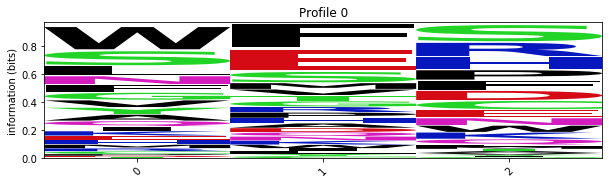

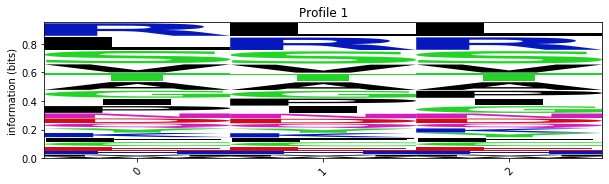

In [12]:
# print up to 5 logos
for i in range(min(U,5)):
    profile_df = dfs[i]
    logo = logomaker.Logo(profile_df, vpad=.1, width=1)
    logo.style_xticks(anchor=0, spacing=1, rotation=45)
    logo.ax.set_ylabel('information (bits)')
    logo.ax.set_title(f"Profile {i}")

In [13]:
# dataset = tf.data.Dataset.from_tensor_slices([X])